# <center>Big Data For Engineers&ndash; Solutions</center>
## <center>Spring 2025 &ndash; Week 1 &ndash; ETH Zurich</center>

### Aims
- **After this exercise:** Understand the SQL language and its common query patterns.
- **Later in the semester:** Relate these language features and query patterns relative to other data shapes, technologies, and the languages designed to query them.



- **After this exercise:** Understand the 'table' data shape, normalization, and when they can (and should) be used.
- **Later in the semester:** Understand when you can (and should) throw all of this away!

### Prerequisites
In this exercise, you will brush-up the fundamental concepts of relational databases and SQL. If you haven't taken an introductory databases course (or want to refresh your knowledge) we recommend you to read the following:

Garcia-Molina, Ullman, Widom: Database Systems: The Complete Book. Pearson, 2. Edition, 2008. (Chapters 1, 2, 3, and 6) [Available in the ETH Library] [[Online]](https://ebookcentral.proquest.com/lib/ethz/detail.action?pq-origsite=primo&docID=5832965) [[Selected solutions]](http://infolab.stanford.edu/~ullman/dscbsols/sols.html)

### Database Set-up

Unlike last week's exercise, the dataset for this exercise might take a little bit longer to download and initialize. Please wait for the message `PostgreSQL init process complete; ready for start up` in the terminal before proceeding!

As before, we set up our connection to the database and enable use of `%sql` and `%%sql`.

In [1]:
server='db'
user='postgres'
password='example'
database='postgres'
connection_string=f'postgresql://{user}:{password}@{server}:5432/{database}'

In [2]:
%reload_ext sql
%sql $connection_string

In [3]:
%%sql
SELECT version();

 * postgresql://postgres:***@db:5432/postgres
1 rows affected.


version
"PostgreSQL 16.0 (Debian 16.0-1.pgdg120+1) on aarch64-unknown-linux-gnu, compiled by gcc (Debian 12.2.0-14) 12.2.0, 64-bit"


## Exercise 1: Explore the dataset
We want to first understand the dataset a bit better. You will find some queries below to help you explore the schema. In the process, consider the following questions:

1. Which concepts are modelled in the dataset and how do they relate to each other?
2. The data is stored as tables. Why was this shape chosen and why not the other shapes?
3. In which normal forms are the corresponding relations?
4. What are the efficiency trade-offs from adding an `artist_id` and `artist_name` directly to the `releases` table? Hints:
   - What are some typical queries that would benefit from this change?
   - How often do we need to update artists?
5. What potential problems could result from adding this redundancy?

### Where we got the data from
- [Discogs](https://www.discogs.com/)
- [Discogs XML data dumps](http://data.discogs.com/)
- [Download the dataset](https://cloud.inf.ethz.ch/s/4bZWo4TjeXgCNz5) (only necessary if you don't want to use Docker, see `postgres-init.sh` to see how to import it)

### List tables
The following query retrieves a list of tables in the database from a system table describing the current database.

In [4]:
%%sql 
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public';

 * postgresql://postgres:***@db:5432/postgres
4 rows affected.


table_name
artists
released_by
releases
tracks


### List attributes/columns
The following query retrieves a list of columns from the tables in the database.

In [5]:
%%sql 
SELECT table_name, column_name, data_type, is_nullable, ordinal_position
FROM information_schema.columns
WHERE table_schema = 'public' AND table_name IN ('artists', 'released_by', 'releases', 'tracks')
AND table_name NOT LIKE 'pg_%'
ORDER BY table_name, ordinal_position;

 * postgresql://postgres:***@db:5432/postgres
17 rows affected.


table_name,column_name,data_type,is_nullable,ordinal_position
artists,artist_id,integer,NO,1
artists,name,character varying,YES,2
artists,realname,text,YES,3
artists,profile,text,YES,4
artists,url,text,YES,5
released_by,release_id,integer,NO,1
released_by,artist_id,integer,NO,2
releases,release_id,integer,NO,1
releases,released,date,NO,2
releases,title,text,NO,3


### Exercise 1: Solution
1. Which concepts are modelled in the dataset and how do they relate to each other?

   The dataset contains data from `discogs` and models musical artists, their physical releases, and the tracks on those releases.

2. The data is stored as tables. Why was this shape chosen and why not the other shapes?
   - The number of concepts is limited, fixed, and well-defined.
   - The same is true for attributes of these concepts.
   - Attributes come from a well-defined domains with a fixed semantic (such as dates, e-mail addresses, ...).
   - Instances of concepts are in relation with each other, which may or may not be required to exist.
   - In short: we can define a schema, which the rest of the application (the website) relies on.


3. In which normal forms are the corresponding relations?

   - All relations are atomic so they are in 1NF.
   - `artists` and `releases` both have a singular ID primary key, so they at least 2NF. Upon inspection, there are no transitive dependencies, so they are in 3NF.
   - `released_by` does not contain non-key attributes, so it is in 3NF.
   - `tracks` has a foreign key constraint but no primary key constraint (although this is not captured by normal forms). The reason is likely because the data is crowd-sourced and archival, and there could be duplicate entries in the database.


4. What are the efficiency trade-offs from adding an `artist_id` and `artist_name` directly to the `releases` table? Hints:

   - What are some typical queries that would benefit from this change?
   - How often do we need to update artists?
   
   A very typical query is finding all the releases by an artist's name. If we redundantly store the artist's ID and name in `releases`, the aforementioned query now only requires a `SELECT` instead of an expensive `JOIN`. As releases can be released by multiple artists, we could also extend this idea and break 1NF by storing a list of artist names instead. The tradeoff here is that every time we have to update an artist's name we have to find and update all releases by that artist. Considering that reads are very common and changes are rare, the option of denormalizing becomes relatively more attractive.

5. What potential problems could result from denormalizing the data?

   - Insert anomaly: we could insert a release with a fake or incorrect artist name.
   - Update anomaly: if we update an artist's name but not all of the records in `releases`, we introduce an inconsistency into the dataset.

## Exercise 2: SQL warm-up
Let us begin with several SQL queries to ease us back into the language.

1. Retrieve all artists with the name of 'Radiohead'.

In [6]:
%%sql
SELECT * FROM artists WHERE name = 'Radiohead';

 * postgresql://postgres:***@db:5432/postgres
1 rows affected.


artist_id,name,realname,profile,url
3840,Radiohead,None,"Alternative Rock (Modern Rock) band from Oxfordshire, England (United Kingdom). The name Radiohead comes from the [a=Talking Heads] song, ""Radio Head"", from the ""[url=http://www.discogs.com/Talking-Heads-True-Stories/master/39386]True Stories[/url]"" album. Formed by school friends in 1986, Radiohead did not release their first single until 1992's ""[r=767600]"". The cathartic ""[url=http://www.discogs.com/Radiohead-Creep/master/21481]Creep[/url]"", from the debut album ""[url=http://www.discogs.com/Radiohead-Pablo-Honey/master/13344]Pablo Honey[/url]"" (1993), became a worldwide hit as grunge music dominated radio airwaves. Radiohead were initially branded as a one-hit wonder abroad, but caught on at home in the UK with their second album, ""[url=http://www.discogs.com/Radiohead-The-Bends/master/17008]The Bends[/url]"" (1995), earning fans with their dense guitar atmospheres and front man [a=Thom Yorke]'s expressive singing. The album featured the hits ""[url=http://www.discogs.com/Radiohead-High-Dry-Planet-Telex/release/199387]High & Dry[/url]"", ""[r=1463625]"" and ""[url=http://www.discogs.com/Radiohead-Fake-Plastic-Trees/master/21526]Fake Plastic Trees[/url]"". The band's third album, ""[url=http://www.discogs.com/Radiohead-OK-Computer/master/21491]OK Computer[/url]"" (1997), propelled them to greater attention. Popular both for its expansive sound and themes of modern alienation, the album has been acclaimed by critics as a landmark record of the 1990's, some critics go as far to consider it one of the best of all time. ""[url=http://www.discogs.com/Radiohead-Kid-A/master/21501]Kid A[/url]"" (2000) marked further evolution, containing influences from experimental electronic music. ""[url=http://www.discogs.com/Radiohead-Hail-To-The-Thief/master/16962]Hail To The Thief[/url]"" (2003) was seen as a conventional return to the guitar and piano-led rock sound. After fulfilling their contract with EMI, Radiohead released ""[url=http://www.discogs.com/Radiohead-In-Rainbows/master/21520]In Rainbows[/url]"" (2007) famously via a pay-what-you-want model. Their latest album, ""[url=https://www.discogs.com/Radiohead-A-Moon-Shaped-Pool/master/998252]A Moon Shaped Pool[/url]"", was released in May 2016. Radiohead's original influences were cited as alternative rock and post-punk bands like [url=http://www.discogs.com/artist/Smiths,+The]The Smiths[/url], [a=Pixies], [a=Magazine], [a=Joy Division], and [a=R.E.M.] (with lead singer of the band, Thom Yorke, refering to himself as an 'R.E.M. groupie').",http://www.radiohead.com


2. List the titles of all releases by that artist in alphabetical order.

In [7]:
%%sql
SELECT DISTINCT releases.title
FROM artists
JOIN released_by USING(artist_id)
JOIN releases USING(release_id)
WHERE artists.name = 'Radiohead'
ORDER BY releases.title;

 * postgresql://postgres:***@db:5432/postgres
61 rows affected.


title
2+2=5
27 5 94 The Astoria London Live
7 Television Commercials
7 Television Commercials.
Airbag / How Am I Driving?
Ale To The Thieves
Amnesiac
Anyone Can Play Guitar
A Punchup At A Wedding
Beats And Breaks


3. List the titles of all releases by that artist that contain less than 5 tracks.

In [8]:
%%sql
SELECT releases.title, COUNT(*) AS num_tracks
FROM artists
JOIN released_by USING(artist_id)
JOIN releases USING(release_id)
JOIN tracks USING(release_id)
WHERE artists.name = 'Radiohead'
GROUP BY releases.release_id, releases.title
HAVING COUNT(*) < 5;

 * postgresql://postgres:***@db:5432/postgres
76 rows affected.


title,num_tracks
Karma Police,3
Climbing Up The Walls (Remixes),2
High & Dry / Planet Telex,4
Everything In Its Right Place (House Mix),1
Planet Telex,4
Pyramid Song,3
Knives Out,3
Pyramid Song,3
Knives Out,3
Street Spirit,1


4. What are the top 10 artists with the most releases?

In [9]:
%%sql
SELECT artists.artist_id, artists.name, COUNT(*) AS num_releases
FROM artists
JOIN released_by USING(artist_id)
JOIN releases USING(release_id)
GROUP BY artists.artist_id, artists.name
ORDER BY num_releases DESC
LIMIT 10;

 * postgresql://postgres:***@db:5432/postgres
10 rows affected.


artist_id,name,num_releases
194,Various Artists,46123
2725,Depeche Mode,1053
8760,Madonna,617
7552,Pet Shop Boys,600
1031,Moby,546
3909,New Order,454
2714,Erasure,448
28972,The Cure,417
6520,U2,365
66852,The Prodigy,355


5. How many artists have more releases than the average number of releases per artists (who have at least 1 release)

In [10]:
%%sql

SELECT COUNT(*)
FROM (
    SELECT COUNT(*) AS release_count
    FROM artists
    JOIN released_by USING(artist_id)
    JOIN releases USING(release_id)
    GROUP BY artists.artist_id) releases_per_artist
WHERE release_count > 
            (SELECT AVG(release_count)
             FROM
               (SELECT COUNT(*) AS release_count
                FROM artists
                JOIN released_by USING(artist_id)
                JOIN releases USING(release_id)
                GROUP BY artists.artist_id) releases_per_artist)

 * postgresql://postgres:***@db:5432/postgres
1 rows affected.


count
23632


6. What are the names and IDs of the artists that have both a release with the genre 'Pop' *and* a release with the genre 'Classical'? Give a query that uses `INTERSECT` and one that uses `EXISTS`.

In [13]:
%%sql
SELECT artists.artist_id, artists.name
FROM artists
JOIN released_by USING(artist_id)
JOIN releases USING(release_id)
WHERE releases.genre = 'Pop'
INTERSECT
SELECT artists.artist_id, artists.name
FROM artists
JOIN released_by USING(artist_id)
JOIN releases USING(release_id)
WHERE releases.genre = 'Classical'

 * postgresql://postgres:***@db:5432/postgres
11 rows affected.


artist_id,name
273394,John Williams (4)
407111,Kurt Weill
194,Various Artists
10263,David Bowie
59756,Sarah Brightman
39575,James Horner
283111,Maurice Jarre
15900,Ennio Morricone
208267,Jerry Goldsmith
59633,Andrew Poppy


In [14]:
%%sql
SELECT a1.artist_id, a1.name
FROM artists a1
WHERE EXISTS (
    SELECT *
    FROM artists a2
    JOIN released_by USING(artist_id)
    JOIN releases USING(release_id)
    WHERE releases.genre = 'Pop'
    AND a1.artist_id = a2.artist_id
) AND EXISTS (
    SELECT *
    FROM artists a2
    JOIN released_by USING(artist_id)
    JOIN releases USING(release_id)
    WHERE releases.genre = 'Classical'
    AND a1.artist_id = a2.artist_id
)

 * postgresql://postgres:***@db:5432/postgres
11 rows affected.


artist_id,name
15900,Ennio Morricone
283111,Maurice Jarre
208267,Jerry Goldsmith
10263,David Bowie
194,Various Artists
273394,John Williams (4)
39575,James Horner
59633,Andrew Poppy
7779,Penguin Cafe Orchestra
407111,Kurt Weill


## Exercise 3: Impact of release genre on average track duration and track count
For this exercise, we want to find out how average track duration and track count varies across genres.

To start, write a query which finds all of the distinct genres:

In [15]:
%%sql
SELECT DISTINCT genre
FROM releases;

 * postgresql://postgres:***@db:5432/postgres
15 rows affected.


genre
Blues
Brass & Military
Children's
Classical
Electronic
"Folk, World, & Country"
Funk / Soul
Hip Hop
Jazz
Latin


Take a guess as to which genre has:
1. The highest average track count?
2. The lowest average track count?
3. The longest average track duration?
4. The shortest average track duration?

Next, write a query to calculate the average track count per genre:

In [16]:
%%sql 
SELECT tracks_per_release.genre, AVG(tracks_per_release.track_count) AS avg_track_count
FROM 
    (SELECT releases.genre, COUNT(*) AS track_count
    FROM releases JOIN tracks USING(release_id)
    GROUP BY releases.release_id, releases.genre) tracks_per_release
GROUP BY tracks_per_release.genre
ORDER BY avg_track_count

 * postgresql://postgres:***@db:5432/postgres
15 rows affected.


genre,avg_track_count
Funk / Soul,5.8397790055248619
Electronic,6.0605250257308610
Pop,7.5562060889929742
Hip Hop,8.4942405038064490
Reggae,8.9691318327974277
Rock,9.3996764452113891
Classical,9.5450980392156863
Brass & Military,10.0000000000000000
Latin,10.0771208226221080
Non-Music,10.3572695035460993


Write a query to calculate the average duration per genre. Your result should have two attributes: `genre` and `avg_duration`.

In [17]:
%%sql
SELECT releases.genre, AVG(tracks.duration) AS avg_duration
FROM releases JOIN tracks USING(release_id)
GROUP BY releases.genre
ORDER BY avg_duration

 * postgresql://postgres:***@db:5432/postgres
15 rows affected.


genre,avg_duration
Stage & Screen,232.7167019027484144
Blues,241.7623430962343096
Pop,250.8255075158840849
Rock,264.4566639664592938
Brass & Military,266.6083333333333333
Latin,271.9007653061224490
Hip Hop,276.7896082810916326
Reggae,286.1795368179536818
Children's,290.4801980198019802
Funk / Soul,292.1099810785241249


Did the results match what you expected? Copy your queries into the following python script to plot the result.

 * postgresql://postgres:***@db:5432/postgres
15 rows affected.
['Stage & Screen', 'Blues', 'Pop', 'Rock', 'Brass & Military', 'Latin', 'Hip Hop', 'Reggae', "Children's", 'Funk / Soul', 'Folk, World, & Country', 'Jazz', 'Electronic', 'Non-Music', 'Classical']
[Decimal('232.7167019027484144'), Decimal('241.7623430962343096'), Decimal('250.8255075158840849'), Decimal('264.4566639664592938'), Decimal('266.6083333333333333'), Decimal('271.9007653061224490'), Decimal('276.7896082810916326'), Decimal('286.1795368179536818'), Decimal('290.4801980198019802'), Decimal('292.1099810785241249'), Decimal('293.7428247734138973'), Decimal('301.5316479824634556'), Decimal('340.6974249708554896'), Decimal('347.9161174355901738'), Decimal('368.9800739523418242')]


Text(0, 0.5, 'Genre')

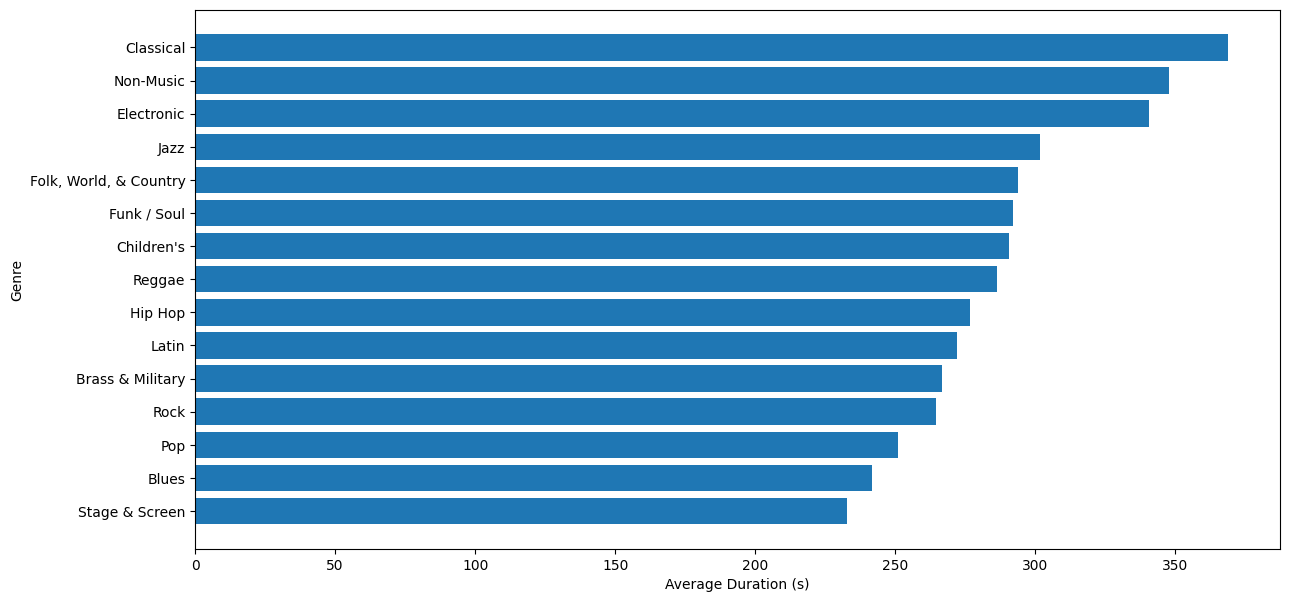

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

# Store the result of the query in a Python object (add your query here!)
result = %sql   SELECT releases.genre, AVG(tracks.duration) AS avg_duration \
                FROM releases JOIN tracks USING(release_id) \
                GROUP BY releases.genre \
                ORDER BY avg_duration ASC; \

# Convert the result to a Pandas data frame
df = result.DataFrame()

# Extract x and y values for a plot
x = df['genre'].tolist()
y = df['avg_duration'].tolist()

# Print them just for debugging
print(x)
print(y)

# Plot the distribution of scores
fig = plt.figure(figsize =(14, 7))
plt.barh(x, y, align='center')
plt.xlabel('Average Duration (s)')
plt.ylabel('Genre')

## Exercise 4: Discuss query patterns and language features of SQL
1. What patterns did you use in many of the queries above?

2. Do you remember the theory behind them?

3. What makes SQL a declarative language and what advantages does that have?

4. What makes SQL a functional language and what advantages does that have?

### Exercise 4: Solution
1. Most queries consist of the following basic operations. They will reoccur throughout the whole semester. Watch out for them!
  * **Select**: select a subset of the rows/data records/items.
  * **Project**: select a subset of the properties/ attributes/columns.
  * **Join**: bring two datasets together based on a common attribute.
  * **Group**: divide the items/ rows/records into groups and summarize each group with a single value.
  * **Order**: order the items according to some criteria.
  
2. Relational algebra operators formalize most of this (grouping is technically not part of the algebra).
  
3. We only describe *what* we want, not how this should be computed. We *declare* what our intent is. This shifts the implementation effort from the programmer to the database system. The hope is that the system has more information at hand, such as data size, data distribution, information about the hardware, in order to choose the best way to compute the result. This results into efficient computation with little effort from the programmer.
  
4. SQL is functional because results of a query can be used as input of another query, either in form of tables or in form of scalars. This makes SQL expressive.